In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from scipy.optimize import fsolve


sns.set_style("ticks", {"axes.linewidth":0.5})


#plt.rc('text.latex', preamble=r'\usepackage{color}')
smallfs = 8
bigfs = 10
plt.rc('font', size=smallfs)          # Ticklabels, legend labels, etc.
plt.rc('axes', labelsize=bigfs)    # Axis labels
plt.rc('axes', titlesize=bigfs)    # Titles


In [2]:
def get_C_T(covMat):
    eigval, evec = np.linalg.eig(covMat)   # returns w, v: column ``v[:,i]`` is the eigenvector corresponding to the  eigenvalue ``w[i]``.
    C_p = np.array([eigval[ni]**0.5 * evec[:,ni] for ni, i in enumerate(range(covMat.shape[0]))]).T
    Cinv_p = np.linalg.inv(C_p)
    T_p = np.dot(Cinv_p.T, Cinv_p)
    return C_p, T_p

def get_Trafo(data, parties, var=["ccnthum", "wrclmch"]):
    Trafo = {}
    CSS_dict = {}
    for r in [0]:
        
        X_train = data #data.loc[data.essround==r, var].dropna(how="any", axis="index").to_numpy()
        Call, Tall = get_C_T(np.cov(X_train.T))
        Trafo[r] = {"None": Tall}
        CSS_dict[r] = {"None": Call}
        
        for p_id, p in parties.items():
            if not (p_id == 0):
                X_train = data  #data.loc[(data.essround==r) & (data.identity==p_id), var].dropna(how="any", axis="index").to_numpy()
                C_p, T_p = get_C_T(np.cov(X_train.T))
                if len(var)>1:
                   assert (np.dot(C_p[:,0], C_p[:,1] ) <1e-15)    
                CSS_dict[r][p] = C_p
                Trafo[r][p] = T_p
                
    return CSS_dict, Trafo
        

# Plot the sketch

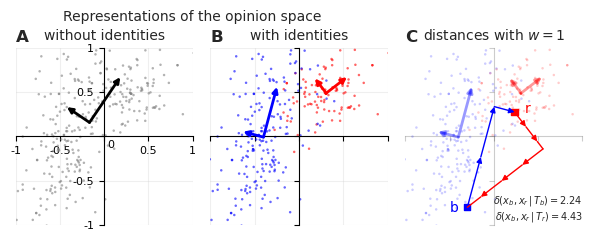

In [3]:
np.random.seed(1)
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(16/2.54,5.8/2.54))

np.random.seed(2)
upper_cluster = np.random.random(size=[2,1000]) *0.5 + 0.4
left_cluster = -np.random.random(size=[2,1000]) *0.5 - 0.4
upper_cluster = np.random.multivariate_normal(np.array([0.3,0.5]), 0.6*np.array([[0.1, 0.04], [0.04, 0.1]]), size=2000).T
left_cluster = np.random.multivariate_normal(-np.array([0.4,0.]), 0.3*np.array([[0.25, 0.2], [0.2, 1.2]]), size=2000).T

X1_u = upper_cluster[:, np.random.choice(range(2000), 100)]
X1_l = left_cluster[:, np.random.choice(range(2000), 0)]
#X2_u = upper_cluster[:, np.random.choice(range(2000), 120)]
X2_l = left_cluster[:, np.random.choice(range(2000), 200)]
X1 =np.concatenate([X1_u.T, X1_l.T])
X2 =X2_l.T # np.concatenate([X2_u.T, X2_l.T])
X = np.concatenate([X1, X2])

idsNone = ["grey"]*len(X[:, 0])
idsSI =  ["red"]*len(X1[:, 0]) + ["blue"]*len(X2[:, 0])

for ax, ids, data, parties in zip([ax1, ax2, ax3], 
                                  [idsNone, idsSI, idsSI],
                                  [{"black":X}, {"red":X1, "blue":X2}, {"red":X1, "blue":X2}],
                                  [{"None":"black"}, {1:"red", 2:"blue"}, {1:"red", 2:"blue"}]):
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_aspect("equal")
    
    ax.scatter(X[:, 0], X[:, 1], edgecolors="none", c=ids, alpha=0.6 if not ax==ax3 else 0.2, s=13, marker=".")

    for id, p in parties.items():
        cssdict, trafo = get_Trafo(data[p], {id:p})
        T = cssdict[0][p]
        if p=="blue" or p=="black":
            T[:, 1] = -T[:, 1]
        arrowprops = dict(shrinkA=0, shrinkB=0, arrowstyle="<|-", color=p,lw=2, alpha=0.4 if ax==ax3 else 1, edgecolor=None)
        
        scale=1
        start = np.mean(data[p], axis=0)
        ax.annotate("", start, start+scale*T[:, 0], arrowprops=arrowprops)
        ax.annotate("", start, start+scale*T[:, 1], arrowprops=arrowprops, )


for ax in [ax1, ax2, ax3]:
    ax.spines["left"].set_position("zero")
    ax.spines["bottom"].set_position("zero")
    ax.spines[["left", "bottom"]].set_color((0,0,0,0.2) if ax==ax3 else (0,0,0,1))
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.grid(alpha=0.0 if ax==ax3 else 0.3)
    #ax.plot(0, 1, "^k", transform=ax.get_xaxis_transform(), clip_on=False, alpha=0.2 if ax==ax3 else 1)
    #ax.plot(1, 0, ">k", transform=ax.get_yaxis_transform(), clip_on=False, alpha=0.2 if ax==ax3 else 1)
    ax.set_yticks([-1,-0.5, 0,0.5,1])
    ax.set_xticks([-1,-0.5, 0,0.5,1])
    if ax == ax1:
        ax.set_yticklabels([-1,-0.5, "",0.5,1])
        ax.set_xticklabels([-1,-0.5, "",0.5,1])
        ax.text( 0.04, -0.04,"0", rotation=0, color="k", ha="left", va="top")
    else:
        ax.set_xticklabels([])
        ax.set_yticklabels([])
    ax.tick_params(axis='both', colors=(0,0,0,0.2) if ax==ax3 else (0,0,0,1))

X = (-0.3, -0.8)
p="blue"
cssdictB, trafoB = get_Trafo(X2, {1:"red", 2:"blue"})
T = cssdictB[0][p]
if p=="blue" or p=="black":
    T[:, 1] = -T[:, 1]
    T[:, 0] = -T[:, 0]
arrowprops = dict(shrinkA=0, shrinkB=0, arrowstyle="<|-", color=p,lw=1, alpha=1, edgecolor=None)
   
scale=1
start = X
Y = X + 2 * scale*T[:, 1]+ 1 * scale*T[:, 0]

ax3.annotate("", X, X+scale*T[:, 1], arrowprops=arrowprops, )
ax3.annotate("", X+scale*T[:, 1], X+2*scale*T[:, 1], arrowprops=arrowprops, )
ax3.annotate("", X+2*scale*T[:, 1], Y, arrowprops=arrowprops)

p="red"
cssdictR, trafoR = get_Trafo(X1, {1:"red", 2:"blue"})
arrowprops["color"] = p
T = cssdictR[0][p]

def x(x, a,b):
    return a * cssdictB[0]["blue"][:, 0] + b * cssdictB[0]["blue"][:, 1] -  (x[0]*  cssdictR[0]["red"][:, 0] + x[1] * cssdictR[0]["red"][:, 1]) 
redFactors = fsolve(x, (3, 2), args=(1,2))


end = Y
for k in [-1, -1, -redFactors[1]+2]:
    start = end
    end = start + k * T[:, 1]
    arrowprops["arrowstyle"] = "<|-" if k==-1 else "-"
    ax3.annotate("", start, end, arrowprops=arrowprops, )
for k in [-1, -1, -1, -redFactors[0]+3]:
    start = end
    end = start + k * T[:, 0]
    arrowprops["arrowstyle"] = "<|-" if k==-1 else "-"
    ax3.annotate("", start, end, arrowprops=arrowprops, )
    
#ax3.annotate("", start+2*scale*T[:, 1]+scale*T[:, 0], start+2*scale*T[:, 1]+2*scale*T[:, 0], arrowprops=arrowprops)
ax3.scatter((X[0],Y[0]), (X[1],Y[1]), marker="s", c=["b", "r"], s=20 )

ax3.text(X[0]-0.1, X[1], r"b", ha="right", va="center", color="b", fontsize=bigfs)
ax3.text(Y[0]+0.12, Y[1]+0.04, r"r", ha="left", va="center", color="r", fontsize=bigfs)
delta_b_br = np.dot((X-Y).T, np.dot(trafoB[0]["blue"], (X-Y)))**0.5
delta_r_br = np.dot((X-Y).T, np.dot(trafoR[0]["red"], (X-Y)))**0.5

ax3.text(1, -0.98, rf"$\delta  (x_b, x_r \, | \, T_b)= {delta_b_br:.2f}$" +"\n"+ rf"$\delta (x_b, x_r \, | \, T_r) = {delta_r_br:.2f}$", va="bottom", ha="right", fontsize=smallfs-1)

ax1.text(0.0, 1.02, "A", va="bottom", ha="left", fontdict={"weight":"bold", "size":12}, transform=ax1.transAxes)
ax2.text(0.0, 1.02, "B", va="bottom", ha="left", fontdict={"weight":"bold", "size":12}, transform=ax2.transAxes)
ax3.text(0.0, 1.02, "C", va="bottom", ha="left", fontdict={"weight":"bold", "size":12}, transform=ax3.transAxes)

fig.suptitle(r"Representations of the opinion space", x=0.33, fontsize=bigfs, y=0.97, va="top")
ax1.set_title(r"without identities", fontsize=bigfs)
ax2.set_title(r"with identities", fontsize=bigfs)
ax3.set_title(r"distances with $w=1$", fontsize=bigfs)

#fig.set_facecolor("yellow")
fig.subplots_adjust(bottom=0.02, left=0.05, right=0.95, top=0.81, hspace=0.05, wspace=0.1)
plt.savefig("figs/polarisedExample_deltaExample.pdf")
plt.savefig("figs/polarisedExample_deltaExample.png", dpi=600)

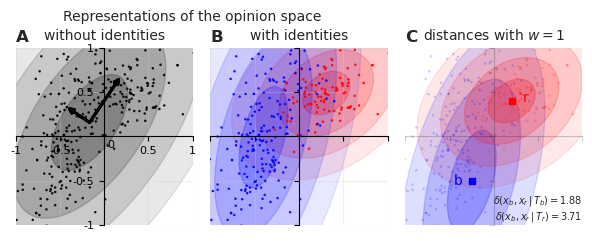

In [35]:
from matplotlib.patches import Ellipse

np.random.seed(1)
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(16/2.54,5.8/2.54))

np.random.seed(2)
upper_cluster = np.random.random(size=[2,1000]) *0.5 + 0.4
left_cluster = -np.random.random(size=[2,1000]) *0.5 - 0.4
upper_cluster = np.random.multivariate_normal(np.array([0.3,0.5]), 0.6*np.array([[0.1, 0.04], [0.04, 0.1]]), size=2000).T
left_cluster = np.random.multivariate_normal(-np.array([0.4,0.]), 0.3*np.array([[0.25, 0.2], [0.2, 1.2]]), size=2000).T

X1_u = upper_cluster[:, np.random.choice(range(2000), 100)]
X1_l = left_cluster[:, np.random.choice(range(2000), 0)]
#X2_u = upper_cluster[:, np.random.choice(range(2000), 120)]
X2_l = left_cluster[:, np.random.choice(range(2000), 200)]
X1 =np.concatenate([X1_u.T, X1_l.T])
X2 =X2_l.T # np.concatenate([X2_u.T, X2_l.T])
X = np.concatenate([X1, X2])

idsNone = ["k"]*len(X[:, 0])
idsSI =  ["red"]*len(X1[:, 0]) + ["blue"]*len(X2[:, 0])

for ax, ids, data, parties in zip([ax1, ax2, ax3], 
                                  [idsNone, idsSI, idsSI],
                                  [{"black":X}, {"red":X1, "blue":X2}, {"red":X1, "blue":X2}],
                                  [{"None":"black"}, {1:"red", 2:"blue"}, {1:"red", 2:"blue"}]):
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_aspect("equal")
    
    ax.scatter(X[:, 0], X[:, 1], edgecolors="none", c=ids, alpha=0.9 if not ax==ax3 else 0.2, s=13, marker=".")

    for id, p in parties.items():
        cssdict, trafo = get_Trafo(data[p], {id:p})
        T = cssdict[0][p]
        if p=="blue" or p=="black":
            T[:, 1] = -T[:, 1]
        #
        #scale=1
        start = np.mean(data[p], axis=0)
        #ax.annotate("", start, start+scale*T[:, 0], arrowprops=arrowprops)
        #ax.annotate("", start, start+scale*T[:, 1], arrowprops=arrowprops, )
        
        angle = np.arctan2(T[:, 0][1], T[:, 0][0]) * 180 / np.pi
        for n in [4,3,2,1]:
            ellipse = Ellipse(start, n*2*np.linalg.norm(T[:, 0]), n*2*np.linalg.norm(T[:, 1]), angle=angle, edgecolor=p, fc=p, alpha=max(0,0.25-0.04*n), lw=1, zorder=0)
            if not ax==ax3:
                ax.add_patch(ellipse)
            if ax == ax1:
                arrowprops = dict(shrinkA=0, shrinkB=0, arrowstyle="<|-", color=p,lw=2, alpha=0.4 if ax==ax3 else 1, edgecolor=None)
                ax.annotate("", start, start+T[:, 1], arrowprops=arrowprops, )
                ax.annotate("", start, start+T[:, 0], arrowprops=arrowprops, )

for ax in [ax1, ax2, ax3]:
    ax.spines["left"].set_position("zero")
    ax.spines["bottom"].set_position("zero")
    ax.spines[["left", "bottom"]].set_color((0,0,0,0.2) if ax==ax3 else (0,0,0,1))
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.grid(alpha=0.0 if ax==ax3 else 0.3)
    #ax.plot(0, 1, "^k", transform=ax.get_xaxis_transform(), clip_on=False, alpha=0.2 if ax==ax3 else 1)
    #ax.plot(1, 0, ">k", transform=ax.get_yaxis_transform(), clip_on=False, alpha=0.2 if ax==ax3 else 1)
    ax.set_yticks([-1,-0.5, 0,0.5,1])
    ax.set_xticks([-1,-0.5, 0,0.5,1])
    if ax == ax1:
        ax.set_yticklabels([-1,-0.5, "",0.5,1])
        ax.set_xticklabels([-1,-0.5, "",0.5,1])
        ax.text( 0.04, -0.04,"0", rotation=0, color="k", ha="left", va="top")
    else:
        ax.set_xticklabels([])
        ax.set_yticklabels([])
    ax.tick_params(axis='both', colors=(0,0,0,0.2) if ax==ax3 else (0,0,0,1))

X = (-0.25, -0.5)
p="blue"
cssdictB, trafoB = get_Trafo(X2, {1:"red", 2:"blue"})
T = cssdictB[0][p]
if p=="blue" or p=="black":
    T[:, 1] = -T[:, 1]
    T[:, 0] = -T[:, 0]
arrowprops = dict(shrinkA=0, shrinkB=0, arrowstyle="<|-", color=p,lw=1, alpha=1, edgecolor=None)

angle = np.arctan2(T[:, 0][1], T[:, 0][0]) * 180 / np.pi
for n in [3,2,1]:
    ellipse = Ellipse(X, n *2* np.linalg.norm(T[:, 0]), n * 2*np.linalg.norm(T[:, 1]), angle=angle, edgecolor=p, fc=p, alpha=max(0,0.25-0.04*n), lw=1, zorder=0)
    ax3.add_patch(ellipse)

#for n in [4]:
#    ellipse = Ellipse(X, n*2*np.linalg.norm(T[:, 0]), n*2*np.linalg.norm(T[:, 1]), angle=angle, edgecolor=p, fc="None", alpha=0.2, lw=1, zorder=0)
#    ax3.add_patch(ellipse)
        
scale=1
start = X
#Y = X + 2 * scale*T[:, 1]+ 1 * scale*T[:, 0]
Y = np.array([0.2,0.4])
#ax3.annotate("", X, X+scale*T[:, 1], arrowprops=arrowprops, )
#ax3.annotate("", X+scale*T[:, 1], X+2*scale*T[:, 1], arrowprops=arrowprops, )
#ax3.annotate("", X+2*scale*T[:, 1], Y, arrowprops=arrowprops)

p="red"
cssdictR, trafoR = get_Trafo(X1, {1:"red", 2:"blue"})
arrowprops["color"] = p
T = cssdictR[0][p]

def x(x, a,b):
    return a * cssdictB[0]["blue"][:, 0] + b * cssdictB[0]["blue"][:, 1] -  (x[0]*  cssdictR[0]["red"][:, 0] + x[1] * cssdictR[0]["red"][:, 1]) 
redFactors = fsolve(x, (3, 2), args=(1,2))


angle = np.arctan2(T[:, 0][1], T[:, 0][0]) * 180 / np.pi
for n in [4,3,2,1]:
    ellipse = Ellipse(Y, n*2*np.linalg.norm(T[:, 0]), n*2*np.linalg.norm(T[:, 1]), angle=angle, edgecolor=p, fc=p, alpha=max(0,0.25-0.04*n), lw=1, zorder=0)
    ax3.add_patch(ellipse)
#for n in [4]:
#    ellipse = Ellipse(Y, n*2*np.linalg.norm(T[:, 0]), n*2*np.linalg.norm(T[:, 1]), angle=angle, edgecolor=p, fc="None", alpha=0.2, lw=1, zorder=0)
#    ax3.add_patch(ellipse)
                

#end = Y
#for k in [-1, -1, -redFactors[1]+2]:
#    start = end
#    end = start + k * T[:, 1]
#    arrowprops["arrowstyle"] = "<|-" if k==-1 else "-"
#    ax3.annotate("", start, end, arrowprops=arrowprops, )
#for k in [-1, -1, -1, -redFactors[0]+3]:
#    start = end
#    end = start + k * T[:, 0]
#    arrowprops["arrowstyle"] = "<|-" if k==-1 else "-"
#    ax3.annotate("", start, end, arrowprops=arrowprops, )
    
#ax3.annotate("", start+2*scale*T[:, 1]+scale*T[:, 0], start+2*scale*T[:, 1]+2*scale*T[:, 0], arrowprops=arrowprops)
ax3.scatter((X[0],Y[0]), (X[1],Y[1]), marker="s", c=["b", "r"], s=20 )

ax3.text(X[0]-0.1, X[1], r"b", ha="right", va="center", color="b", fontsize=bigfs)
ax3.text(Y[0]+0.12, Y[1]+0.04, r"r", ha="left", va="center", color="r", fontsize=bigfs)
delta_b_br = np.dot((X-Y).T, np.dot(trafoB[0]["blue"], (X-Y)))**0.5
delta_r_br = np.dot((X-Y).T, np.dot(trafoR[0]["red"], (X-Y)))**0.5

ax3.text(1, -0.98, rf"$\delta  (x_b, x_r \, | \, T_b)= {delta_b_br:.2f}$" +"\n"+ rf"$\delta (x_b, x_r \, | \, T_r) = {delta_r_br:.2f}$", va="bottom", ha="right", fontsize=smallfs-1)

ax1.text(0.0, 1.02, "A", va="bottom", ha="left", fontdict={"weight":"bold", "size":12}, transform=ax1.transAxes)
ax2.text(0.0, 1.02, "B", va="bottom", ha="left", fontdict={"weight":"bold", "size":12}, transform=ax2.transAxes)
ax3.text(0.0, 1.02, "C", va="bottom", ha="left", fontdict={"weight":"bold", "size":12}, transform=ax3.transAxes)

fig.suptitle(r"Representations of the opinion space", x=0.33, fontsize=bigfs, y=0.97, va="top")
ax1.set_title(r"without identities", fontsize=bigfs)
ax2.set_title(r"with identities", fontsize=bigfs)
ax3.set_title(r"distances with $w=1$", fontsize=bigfs)

#fig.set_facecolor("yellow")
fig.subplots_adjust(bottom=0.02, left=0.05, right=0.95, top=0.81, hspace=0.05, wspace=0.1)
plt.savefig("figs/polarisedExample_deltaExample_ellipse.pdf")
plt.savefig("figs/polarisedExample_deltaExample_ellipse.png", dpi=600)